## Populate a Property Graph

This notebook reports the main steps to download CSV files, process them and create a property graph.

To measure execution time in Jupyter notebooks: <code>pip install ipython-autotime</code>

To connect to Neo4j: <code>pip install neo4j</code>



In [23]:
# required libraries
import pandas as pd
import os
from pathlib import Path
from datetime import datetime, timedelta
from neo4j import GraphDatabase

### Connection to Neo4j

In [24]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "Tennis_DB"))

### Static Methods

In [25]:
# static methods
def create_constraints1_TennisDB(tx):
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (p:Player) REQUIRE p.player_id IS UNIQUE")


def create_constraints2_TennisDB(tx):
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (m:Match) REQUIRE m.match_id IS UNIQUE")


def create_constraints4_TennisDB(tx):
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (c:Country) REQUIRE c.name IS UNIQUE")


def create_constraints5_TennisDB(tx):
    tx.run("CREATE CONSTRAINT IF NOT EXISTS FOR (r:Region) REQUIRE r.name IS UNIQUE")


def create_indexes1(tx):
    tx.run("CREATE INDEX player IF NOT EXISTS FOR (p:Player) ON (p.name_list)")


def create_indexes2(tx):
    tx.run("CREATE INDEX player IF NOT EXISTS FOR (m:Match) ON (m.match_id)")


def create_indexes3(tx):
    tx.run("CREATE INDEX player IF NOT EXISTS FOR (c:Country) ON (c.name)")


def create_indexes4(tx):
    tx.run("CREATE INDEX player IF NOT EXISTS FOR (t:Tourney) ON (t.tourney_name)")


In [26]:
def create_player(tx, player_id, name_first, name_list, hand, birthdate):
    tx.run("MERGE (:Player {player_id: $player_id, name_first: $name_first, name_list: $name_list, hand: $hand, birthdate: date($birthdate)})",
           player_id=player_id, name_first=name_first, name_list=name_list, hand=hand, birthdate=birthdate)


def create_match(tx, match_id, score, best_of, round, minutes, w_ace, l_ace):
    tx.run("MERGE (:Match {match_id: $match_id, score: $score, best_of: $best_of, round: $round, minutes: $minutes, w_ace: $w_ace, l_ace: $l_ace})",
           match_id=match_id, score=score, best_of=best_of, round=round, minutes=minutes, w_ace=w_ace, l_ace=l_ace)

def create_tourney(tx, tourney_name, tourney_date, surface):
    tx.run("MERGE (:Tourney {tourney_name: $tourney_name, tourney_date: date($tourney_date), surface: $surface})",
           tourney_name=tourney_name, tourney_date=tourney_date,surface=surface)


def create_country(tx, name, code, sub_region):
    tx.run("MERGE (:Country {name: $name, code: $code, sub_region: $sub_region})",
           name=name, code=code, sub_region=sub_region)


def create_region(tx, name):
    tx.run("MERGE (:Region {name: $name})",
           name=name)

In [54]:
def connection_to_winner(tx, match_id, player_id):
    tx.run("MATCH (p:Player {player_id: $player_id}), (m:Match {match_id: $match_id}) "
           "MERGE (p)-[r:Winner]->(m)",
           match_id=match_id, player_id=player_id)


def connection_to_loser(tx, match_id, player_id):
    tx.run("MATCH (p:Player {player_id: $player_id}), (m:Match {match_id: $match_id}) "
           "MERGE (p)-[r:Loser]->(m)",
           match_id=match_id, player_id=player_id)


def connection_player_to_country(tx, player_id, country_code):
    tx.run("MATCH (p:Player {player_id: $player_id}), (c:Country {code: $code}) "
           "MERGE (p)-[:hasCountry]->(c)",
           player_id=player_id, code=country_code)


def connection_to_region(tx, countryName, region):
    tx.run("MATCH (c:Country {name: $countryName}), (r:Region {name: $region}) MERGE (c)-[:partOf]->(r)",
           countryName=countryName, region=region)


def connection_tourney_to_match(tx, match_id, tourney_name, tourney_date):
    tx.run("MATCH (t:Tourney {tourney_name: $tourney_name, tourney_date: date($tourney_date)}), (m:Match {match_id: $match_id}) "
           "MERGE (m)-[r:belongsTo]->(t)",
           match_id=match_id, tourney_name=tourney_name, tourney_date=tourney_date)

def connection_tourney_to_country1(tx, country, tourney):
    tx.run("MATCH (t:Tourney {tourney_name: $tourney}), (c:Country {code: $country}) "
           "MERGE (t)-[:located]->(c)",
           country=country, tourney=tourney)


def connection_tourney_to_country2(tx, country, tourney):
    tx.run("MATCH (t:Tourney {tourney_name: $tourney}), (c:Country {name: $country}) "
           "MERGE (t)-[:located]->(c)",
           country=country, tourney=tourney)


def create_node_and_connection_to_rank(tx, player_id, date, rank, points):
    tx.run("MATCH (p:Player {player_id: $player_id}) "
           "MERGE (p)-[:hasRank {date: date($date)}]->(:Rank {rank: $rank, points: $points})",
           player_id=player_id, date=date, rank=rank, points=points)

### Paths

In [45]:
from neo4j import GraphDatabase

# paths for csv files
path = str(Path(os.path.abspath(os.getcwd())).parent.absolute())
atp_players_Url = path + '/databaserunners2/datasets/atp_players.csv'
atp_matches_Url = path + '/databaserunners2/datasets/atp_matches.csv'
countries_Url = path + '/databaserunners2/datasets/Countries.csv'
players_ranking_Url = path + '/databaserunners2/datasets/players_ranking.csv'
all_tournaments_Url = path + '/databaserunners2/datasets/all_tournaments.csv'

In [46]:
# read csv
players = pd.read_csv(atp_players_Url, sep=',', index_col='player_id', keep_default_na=False, na_values=['_'])
atp_matches = pd.read_csv(atp_matches_Url, sep=',', index_col='matches_id', keep_default_na=False, na_values=['_'])
countries = pd.read_csv(countries_Url, sep=',', index_col='name', keep_default_na=False, na_values=['_'])
players_ranking = pd.read_csv(players_ranking_Url, sep=',', index_col='rank', keep_default_na=False, na_values=['_'])
all_tournaments = pd.read_csv(all_tournaments_Url, sep=',', index_col='tournament', keep_default_na=False, na_values=['_'])


### Data ingestion

In [47]:
# create a session
session = driver.session()


In [48]:
# set unique constraints id
session.write_transaction(create_constraints1_TennisDB)
session.write_transaction(create_constraints2_TennisDB)
session.write_transaction(create_constraints4_TennisDB)
session.write_transaction(create_constraints5_TennisDB)


# create the indexes
session.write_transaction(create_indexes1)
session.write_transaction(create_indexes2)
session.write_transaction(create_indexes3)
session.write_transaction(create_indexes4)

In [32]:
# populate db with players
for index, row in players.iterrows():
    player_id = index
    name_first = row["name_first"]
    name_list = row["name_list"]
    hand = row["hand"]
    s = row["birthdate"]
    if s != '':
        try:
            birthdate = s[0:4]+'-'+s[4:6]+'-'+s[6:8]
            session.write_transaction(create_player, player_id, name_first, name_list, hand, birthdate)
        except ValueError:
            session.run("MERGE (:Player {player_id: $player_id, name_first: $name_first, name_list: $name_list, hand: $hand})",
                player_id=player_id, name_first=name_first, name_list=name_list, hand=hand)
    else:
        session.run("MERGE (:Player {player_id: $player_id, name_first: $name_first, name_list: $name_list, hand: $hand})",
           player_id=player_id, name_first=name_first, name_list=name_list, hand=hand)


In [33]:
# populate db with matches
for index, row in atp_matches.iterrows():
    match_id = index
    score = row["score"]
    best_of = row["best_of"]
    round = row["round"]
    minutes = row["minutes"]
    w_ace = row["w_ace"]
    l_ace = row["l_ace"]
    session.write_transaction(create_match, match_id, score, best_of, round, minutes, w_ace, l_ace)


In [34]:
# populate db with country, region and the connection between these two nodes
for index, row in countries.iterrows():
    name = index
    code = row["code"]
    sub_region = row["sub_region"]
    region = row["region"]
    session.write_transaction(create_country, name, code, sub_region)
    session.write_transaction(create_region, region)
    session.write_transaction(connection_to_region, name, region)



In [55]:
# we have to connect the winner and the loser player to the matches
for index, row in atp_matches.iterrows():
    match_id = index
    winner_id = row["winner_id"]
    loser_id = row["loser_id"]
    if winner_id != '':
        winner = int(winner_id)
        session.write_transaction(connection_to_winner, match_id, winner)
    if loser_id != '':
        loser = int(loser_id)
        session.write_transaction(connection_to_loser, match_id, loser)


In [36]:
# we have to connect players to the respective country
for index, row in players.iterrows():
    player_id = index
    country_code = row["country"]
    session.write_transaction(connection_player_to_country, player_id, country_code)


In [37]:
# populate db with tourney
for index, row in atp_matches.iterrows():
    tourney_name1 = row["tourney_name"]
    tourney_name2 = str(tourney_name1)
    tourney_name3 = tourney_name2.upper()
    d = str(row["tourney_date"])
    surface = row["surface"]
    if d != '':
        try:
            tourney_date = d[0:4]+'-'+d[4:6]+'-'+d[6:8]
            session.write_transaction(create_tourney, tourney_name3, tourney_date, surface)
        except ValueError:
            session.run("MERGE (:Tourney {tourney_name: $tourney_name, surface: $surface})",
                tourney_name=tourney_name3, surface=surface)
    else:
        session.run("MERGE (:Tourney {tourney_name: $tourney_name, surface: $surface})",
            tourney_name=tourney_name3, surface=surface)
       

In [38]:
# connection from match to tourney
for index, row in atp_matches.iterrows():
    match_id = index
    d = str(row["tourney_date"])
    tourney_name1 = row["tourney_name"]
    tourney_name2 = tourney_name1.upper()
    if d != '':
        try:
            tourney_date = d[0:4]+'-'+d[4:6]+'-'+d[6:8]
            session.write_transaction(connection_tourney_to_match, match_id, tourney_name2, tourney_date)
        except ValueError:
            session.run("MATCH (t:Tourney {tourney_name: $tourney_name}), (m:Match {match_id: $match_id}) "
                        "MERGE (m)-[r:belongsTo]->(t)",
                        match_id=match_id, tourney_name=tourney_name2)
    else:
        session.run("MATCH (t:Tourney {tourney_name: $tourney_name}), (m:Match {match_id: $match_id}) "
                    "MERGE (m)-[r:belongsTo]->(t)",
                    match_id=match_id, tourney_name=tourney_name2)
    

In [39]:
# connection from tourney to country
for index, row in all_tournaments.iterrows():
    tourney_name1 = index
    tourney_name2 = str(tourney_name1)
    tourney_name3 = tourney_name2.upper()
    country = str(row["location"])
    session.write_transaction(connection_tourney_to_country1, country, tourney_name3)
    session.write_transaction(connection_tourney_to_country2, country, tourney_name3)

In [40]:
# create node and connection to player's rank
for index, row in players_ranking.iterrows():
    player = row["player"]
    player_id = int(player)
    s = row["ranking_date"]
    rank = index
    rowpoints = row["points"]
    points = int(rowpoints)
    date = '2022-01-03'
    session.write_transaction(create_node_and_connection_to_rank, player_id, date, rank, points)


In [12]:
session.close()

driver.close()

In [90]:
import csv

from matplotlib.pyplot import pie, axis, show
%matplotlib inline

# <font color='red'>Query 1</font>

## "The 10 country with the highest number of players"

### <code>MATCH (p:Player)-[h:hasCountry]->(c:Country)
### RETURN DISTINCT c.name, COUNT(h) AS Number_of_players_per_Country
### ORDER BY Number_of_players_per_Country DESC
### LIMIT 10</code>

In [91]:

### CODE TO SHOW RESULTS OF QUERY
query_1 = csv.reader(open(path+'/databaserunners2/results_queries/query_1.csv'), delimiter=",")

header = next(query_1)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_1:
        col1.append(row[0])
        col2.append(row[1])

query_1_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Country','Number of Players'])

query_1_table

Country Number of Players
0                           United States of America              8786
1                                              Spain              2662
2                                          Australia              2526
3  United Kingdom of Great Britain and Northern I...              2289
4                                              Italy              2286
5                                             France              2229
6                                             Brazil              1991
7                                          Argentina              1636
8                                             Mexico              1228
9                                              Japan              1225

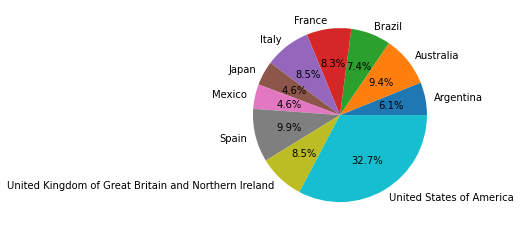

In [92]:
df = pd.read_csv (path+'/databaserunners2/results_queries/query_1.csv')

sums = df.groupby(df["c.name"])["Number_of_players_per_Country"].sum()
axis('equal');
pie(sums, labels=sums.index, autopct='%1.1f%%');
show()

# <font color='red'>Query 2</font>


## "How many matches playes the first 10 ranked player"

### <code>MATCH (r:Rank)<-[]-(p:Player)-[h]->(m:Match)
### WHERE r.rank<=11
### RETURN DISTINCT p.name_list, count(h) AS Number_of_match
### ORDER BY Number_of_match DESC</code>

In [93]:
### CODE TO SHOW RESULTS OF QUERY
query_2 = csv.reader(open(path+'/databaserunners2/results_queries/query_2.csv'), delimiter=",")

header = next(query_2)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_2:
        col1.append(row[0])
        col2.append(row[1])

query_2_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Name Player','Number of Matches'])

query_2_table

Name Player Number of Matches
0            Nadal              1128
1         Djokovic              1034
2           Zverev               275
3         Medvedev               140
4           Rublev               116
5        Tsitsipas               107
6       Berrettini                51
7             Ruud                41
8          Hurkacz                32
9  Auger Aliassime                28

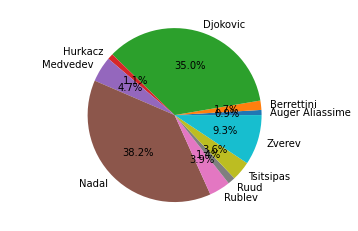

In [94]:
from matplotlib.pyplot import pie, axis, show
%matplotlib inline

df = pd.read_csv (path+'/databaserunners2/results_queries/query_2.csv')

sums = df.groupby(df["p.name_list"])["Number_of_match"].sum()
axis('equal');
pie(sums, labels=sums.index, autopct='%1.1f%%');
show()

# <font color='red'>Query 3</font>

## "Count the players with Left and right hand born after 1980"

## A:
### <code>MATCH (r:Player {hand: 'R'})
### WHERE r.birthdate>=date('1980-01-01')
### WITH count(r) AS Right_hand_players_born_after_1980
### RETURN Right_hand_players_born_after_1980</code>

## B:
### <code>MATCH (l:Player {hand: 'L'})
### WHERE l.birthdate>=date('1980-01-01')
### WITH count(l) AS Left_hand_players_born_after_1980
### RETURN Left_hand_players_born_after_1980</code>

In [104]:
### CODE TO SHOW RESULTS OF QUERY
query_3A = csv.reader(open(path+'/databaserunners2/results_queries/query_3A.csv'), delimiter=",")
query_3B = csv.reader(open(path+'/databaserunners2/results_queries/query_3B.csv'), delimiter=",")

headerA = next(query_3A)
col1 = []
if headerA != None:
    for row in query_3A:
        col1.append(row[0])
        
headerB = next(query_3B)
col2 = []
if headerB != None:
    for row in query_3B:
        col2.append(row[0]) 

query_3_table = pd.DataFrame(zip(col1, col2), \
                            columns=['Right hand Players', 'Left hand Players'])

query_3_table

Right hand Players Left hand Players
0               7914              1013

# <font color='red'>Query 4</font>

## "Average points of Players for the all countries"

### <code>MATCH (p:Player)-[r:hasCountry]->(c:Country) WITH p, c
### MATCH (p)-[:hasRank]->(r:Rank) 
### RETURN  c.name AS Country, avg(r.points) as AVG_Points 
### ORDER BY AVG_Points DESC</code>

In [95]:
### CODE TO SHOW RESULTS OF QUERY
query_4 = csv.reader(open(path+'/databaserunners2/results_queries/query_4.csv'), delimiter=",")

header = next(query_4)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_4:
        col1.append(row[0])
        col2.append(row[1])

query_4_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Country','AVG points'])

query_4_table

Country          AVG points
0                  Norway              1434.0
1                  Serbia   693.6538461538462
2      Russian Federation  368.23529411764747
3   Moldova (Republic of)               314.5
4                  Canada  292.73333333333335
..                    ...                 ...
61                Namibia                 2.0
62                  Ghana                 1.0
63                  Benin                 1.0
64              Singapore                 1.0
65                 Jordan                 1.0

[66 rows x 2 columns]

# <font color='red'>Query 5</font>

## "Count numbers of tournamnets with different surface in europe"

### <code>MATCH (t:Tourney)-[:located]->(c:Country) WITH t,c
### MATCH (c)-[:partOf]->(rg:Region)
### WHERE rg.name="Europe"
### RETURN t.surface, COUNT(t.tourney_name) AS Num_Torney_Europe  ORDER BY t.surface</code>

In [96]:
### CODE TO SHOW RESULTS OF QUERY
query_5 = csv.reader(open(path+'/databaserunners2/results_queries/query_5.csv'), delimiter=",")

header = next(query_5)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_5:
        col1.append(row[0])
        col2.append(row[1])

query_5_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Surface','Number of Tournaments in Europe'])

query_5_table

Surface Number of Tournaments in Europe
0  Carpet                              30
1    Clay                             274
2   Grass                              81
3    Hard                             157

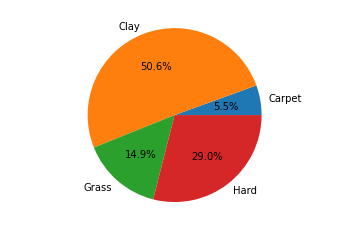

In [97]:
df = pd.read_csv (path+'/databaserunners2/results_queries/query_5.csv')

sums = df.groupby(df["t.surface"])["Num_Torney_Europe"].sum()
axis('equal');
pie(sums, labels=sums.index, autopct='%1.1f%%');
show()

# <font color='red'>Query 6</font>

## "15 Country that host the max number of maches"

### <code>MATCH (t:Tourney)-[:located]->(c:Country) WITH t, c
### MATCH (m:Match)-[:belongsTo]->(t)
### RETURN c.name, COUNT(m) AS Num_matches
### ORDER BY Num_matches DESC
### LIMIT 15</code>

In [105]:
### CODE TO SHOW RESULTS OF QUERY
query_6 = csv.reader(open(path+'/databaserunners2/results_queries/query_6.csv'), delimiter=",")

header = next(query_6)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_6:
        col1.append(row[0])
        col2.append(row[1])
        

query_7_table = pd.DataFrame(zip(col1, col2), \
                            columns=['Country', 'Number of matches host'])

query_7_table

Country Number of matches host
0                            United States of America                   8027
1                                           Australia                   4292
2                                              France                   4087
3   United Kingdom of Great Britain and Northern I...                   3680
4                                             Germany                   2450
5                                               Spain                   1489
6                                             Austria                   1316
7                                         Switzerland                   1250
8                                              Sweden                   1098
9                                         Netherlands                    895
10                                              China                    863
11                                            Croatia                    843
12                                              Japan                    757
13                                             Mexico                    674
14                                             Serbia                    657

# <font color='red'>Query 7</font>

## "The numbers matches were Djokovic wins and lose (first row the wins, second the row the loss)"

### <code>MATCH d=(p1:Player {name_list: 'Djokovic'})-[:Winner]->(m:Match) 
### RETURN count(d) AS Winners_and_Loss 
### UNION 
### MATCH d=(p1:Player {name_list: 'Djokovic'})-[:Loser]->(m:Match) 
### RETURN count(d) AS Winners_and_Loss</code>

In [98]:
### CODE TO SHOW RESULTS OF QUERY
query_7 = csv.reader(open(path+'/databaserunners2/results_queries/query_7.csv'), delimiter=",")

header = next(query_7)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_7:
        col1.append(row[0])
        

query_7_table = pd.DataFrame(zip(col1), \
                            columns=['Win&Lose'])

query_7_table

Win&Lose
0      857
1      181

# <font color='red'>Query 8</font>

## "Count the first 10 players that wins more against Djokivic"

### <code>MATCH (d:Player {name_list: 'Djokovic'})-[l:Loser]->(m:Match)<-[w:Winner]-(p:Player) 
### WITH p.name_list AS name_of_player, size(collect((p)-[w]->(d))) AS number_of_wins, 
### collect(DISTINCT p.name_list) AS player 
### RETURN name_of_player, number_of_wins 
### ORDER BY number_of_wins DESC
### LIMIT 10</code>

In [99]:
### CODE TO SHOW RESULTS OF QUERY
query_8 = csv.reader(open(path+'/databaserunners2/results_queries/query_8.csv'), delimiter=",")

header = next(query_8)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_8:
        col1.append(row[0])
        col2.append(row[1])
        

query_8_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Name Player', 'Number of matches'])

query_8_table

Name Player Number of matches
0       Nadal                25
1     Federer                22
2      Murray                11
3      Tsonga                 7
4      Ferrer                 5
5    Wawrinka                 5
6     Roddick                 5
7    Verdasco                 4
8   Del Potro                 4
9        Haas                 3

# <font color='red'>Query 9</font>

## "The number of matches and the tournaments where Federer partecipates."

### <code>MATCH (p:Player {name_list: 'Federer'})-[]->(m:Match)-[]->(t:Tourney)
### WITH count((p:Player {name_list: 'Federer'})-[]->(m:Match)) AS number_match_of_Federer,
### collect(DISTINCT t.tourney_name) AS tournaments 
### RETURN number_match_of_Federer, tournaments</code>

In [100]:
### CODE TO SHOW RESULTS OF QUERY
query_9 = csv.reader(open(path+'/databaserunners2/results_queries/query_9.csv'), delimiter=",")

header = next(query_9)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_9:
        col1.append(row[0])
        col2.append(row[1])
        

query_9_table = pd.DataFrame(zip(col1,col2), \
                            columns=['Number of tournaments', 'Place'])

query_9_table

Number of tournaments                                              Place
0                  1429  [ROTTERDAM,DUBAI,AUSTRALIAN OPEN,TOUR FINALS,P...

# <font color='red'>Query 10</font>

## "Name of the loser, numbers of match and ace of the winner of the matches where Djokovic wins"

### <code>MATCH (d:Player {name_list: 'Djokovic'})-[w:Winner]->(m:Match)<-[l:Loser]-(p:Player) 
### WITH p, COUNT(m) AS number_of_match , COLLECT(m.w_ace) AS number_of_ace 
### WHERE number_of_match>=2 
### RETURN p.name_list, number_of_match, number_of_ace</code>

In [101]:
### CODE TO SHOW RESULTS OF QUERY
query_10 = csv.reader(open(path+'/databaserunners2/results_queries/query_10.csv'), delimiter=",")

header = next(query_10)
col1, col2, col3, col4 = [],[],[],[]
if header != None:
    for row in query_10:
        col1.append(row[0])
        col2.append(row[1])
        col3.append(row[2])
        

query_10_table = pd.DataFrame(zip(col1,col2,col3), \
                            columns=['Player', 'Number of matches', 'Ace'])

query_10_table

Player Number of matches  \
0          Zib                 3   
1        Nadal                28   
2    Nishikori                18   
3     Medvedev                 3   
4       Tsonga                17   
..         ...               ...   
127     Kiefer                 2   
128  Bracciali                 2   
129      Massu                 2   
130  Goldstein                 2   
131      Coria                 2   

                                                   Ace  
0                                      [16.0,7.0,13.0]  
1    [8.0,23.0,3.0,2.0,4.0,4.0,7.0,3.0,1.0,7.0,5.0,...  
2    [2.0,3.0,6.0,4.0,6.0,,3.0,5.0,5.0,4.0,0.0,6.0,...  
3                                        [6.0,5.0,4.0]  
4    [12.0,1.0,3.0,2.0,14.0,1.0,6.0,8.0,2.0,1.0,4.0...  
..                                                 ...  
127                                         [5.0,11.0]  
128                                         [13.0,8.0]  
129                                          [5.0,9.0]  
130                                          [8.0,8.0]  
131                                          [0.0,2.0]  

[132 rows x 3 columns]